# Cluster Evaluation

In [13]:
import scanpy as sc
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score,normalized_mutual_info_score

# 🧬 导入GenePT对齐工具
import sys
sys.path.append('/root/autodl-tmp/scFastopic')
from genept_alignment import align_genept_for_notebook, load_filtered_genes_from_training_result

0.1


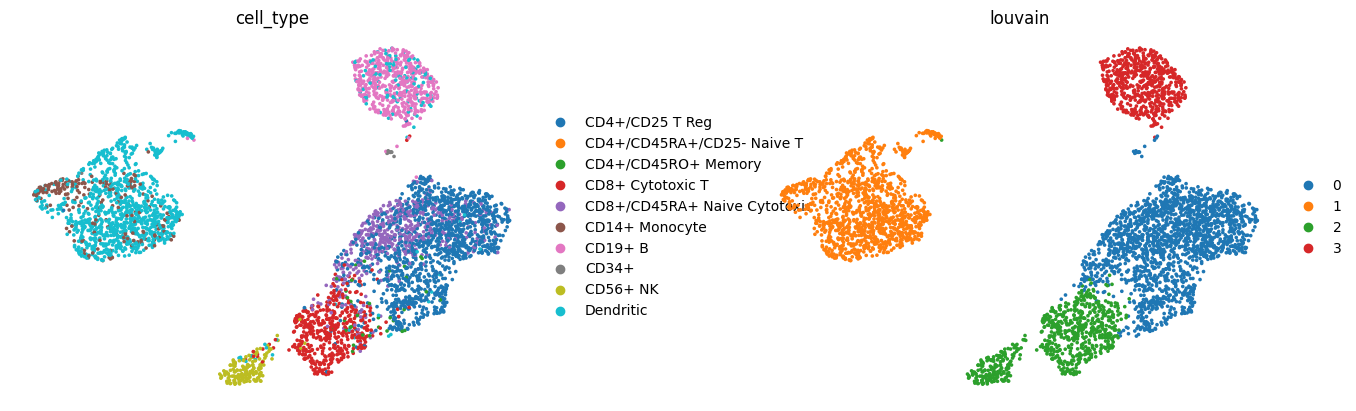

ARI.  0.6250815471448161    NMI.  0.6996699596347422


In [15]:
dataname = 'PBMC4k'
# 加载原始数据获取细胞类型标签
adata_orig = sc.read_h5ad(f'/root/autodl-tmp/scFastopic/data/{dataname}.h5ad')

# 加载cell-topic矩阵作为embedding
import pickle
with open(f'/root/autodl-tmp/scFastopic/results/cell_topic/{dataname}_scVI_align_cell_topic_matrix_50.pkl', 'rb') as f:
    cell_topic_matrix = pickle.load(f)

# 创建AnnData对象
adata = sc.AnnData(cell_topic_matrix)
adata.obs['cell_type'] = adata_orig.obs['cell_type'].values[:adata.n_obs]

sc.pp.pca(adata)
sc.pp.neighbors(adata,use_rep='X')
maxn = 2
minn= 0
list_value = []
for x in  range(minn, maxn*10):
    sc.tl.louvain(adata,resolution=x/10.0,random_state=0)
    list_value.append(adjusted_rand_score(adata.obs['cell_type'],adata.obs['louvain']))
sc.tl.louvain(adata,resolution=list_value.index(max(list_value))*0.1,random_state=0)
print(list_value.index(max(list_value))*0.1)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["cell_type","louvain"],
    wspace = 0.3,
    frameon=False,
    #save = "scE2TM_cluster_"+dataname+".pdf"
)
print("ARI.  "+str(adjusted_rand_score(adata.obs['cell_type'],adata.obs['louvain']))+
      "    NMI.  "+str(normalized_mutual_info_score(adata.obs['cell_type'],adata.obs['louvain']))
      )

# Interpretable Evaluation

In [16]:
import pandas as pd
import gseapy as gp
import numpy as np
kegg = gp.read_gmt(path="/root/autodl-tmp/scFastopic/data/c5.all.v2023.2.Hs.symbols.gmt") 
gene_set = []
cell_gene = []
for value in kegg.values():
    gene_set.extend(value)
    cell_gene.append(value)
gene_set = list(set(gene_set))
dicts_gene_index = {}
for index, value in enumerate(gene_set):
    dicts_gene_index[value] = index
bg_data = np.zeros((len(kegg),len(gene_set)))
for index, values in enumerate(kegg.values()):
    for value in values:
        bg_data[index][dicts_gene_index[value]] = 1

In [17]:
# 测试修改后的notebook - 运行导入和数据加载部分
import scanpy as sc
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score

# 🧬 导入GenePT对齐工具
import sys
sys.path.append('/root/autodl-tmp/scFastopic')
from genept_alignment import align_genept_for_notebook, load_filtered_genes_from_training_result

print("✅ 成功导入所有必要的库和工具")
print("🔧 修复基因维度不匹配问题...")

# 加载topic-gene矩阵
import pickle
with open(f'/root/autodl-tmp/scFastopic/results/topic_gene/{dataname}_scVI_align_topic_gene_matrix_50.pkl', 'rb') as f:
    topic_gene_matrix = pickle.load(f)

print(f"Topic-gene矩阵形状: {topic_gene_matrix.shape}")

# 获取训练时实际使用的基因列表（已过滤到GenePT共有基因）
filtered_genes = load_filtered_genes_from_training_result(dataname)
print(f"实际使用的基因数量: {len(filtered_genes)}")

# 验证维度匹配
if len(filtered_genes) != topic_gene_matrix.shape[1]:
    raise ValueError(f"基因数量不匹配！filtered_genes={len(filtered_genes)}, topic_gene_matrix.shape[1]={topic_gene_matrix.shape[1]}")

# 🎯 执行GenePT对齐
aligned_genept_embeddings, aligned_gene_names, alignment_info = align_genept_for_notebook(
    topic_gene_matrix, filtered_genes
)

print(f"\n✅ 对齐完成！")
print(f"对齐的GenePT embedding形状: {aligned_genept_embeddings.shape}")
print(f"对齐的基因数量: {len(aligned_gene_names)}")

# 创建DataFrame（使用topic-gene权重，基因顺序与GenePT对齐）
data = pd.DataFrame(topic_gene_matrix.T, index=aligned_gene_names)
print(f"DataFrame形状: {data.shape}")

print("\n🎉 基因维度问题已解决！")

✅ 成功导入所有必要的库和工具
🔧 修复基因维度不匹配问题...
Topic-gene矩阵形状: (50, 13963)


📋 获取训练中实际使用的基因:
  原始基因数: 33694
  过滤后基因数: 21241
  过滤掉的基因数: 12453
实际使用的基因数量: 21241


ValueError: 基因数量不匹配！filtered_genes=21241, topic_gene_matrix.shape[1]=13963

## TC

In [6]:
def compute_coherence(cell_gene, topic_gene, N, dicts_gene_tran):
    # print('computing coherence ...')    
    topic_size, gene_size = np.shape(topic_gene)
    cell_size = np.shape(cell_gene)[0]
    # find top genes'index of each topic
    topic_list = []
    for topic_idx in range(topic_size):
        top_gene_idx = np.argpartition(topic_gene[topic_idx, :], -N)[-N:]
        topic_list.append(top_gene_idx)
    #print(topic_list)
    # compute coherence of each topic
    sum_coherence_score = 0.0
    for i in range(topic_size):
        gene_array = topic_list[i]
        sum_score = 0.0
        for n in range(N):
            if gene_array[n] in dicts_gene_tran:
                flag_n = cell_gene[:, dicts_gene_tran[gene_array[n]]] > 0
                p_n = np.sum(flag_n) / cell_size
                for l in range(n + 1, N):
                    if gene_array[l] in dicts_gene_tran:
                        flag_l = cell_gene[:, dicts_gene_tran[gene_array[l]]] > 0
                        p_l = np.sum(flag_l)
                        p_nl = np.sum(flag_n * flag_l)
                        if p_n * p_l * p_nl > 0:
                            p_l = p_l / cell_size
                            p_nl = p_nl / cell_size
                            sum_score += np.log(p_nl / (p_l * p_n)) / -np.log(p_nl)
        sum_coherence_score += sum_score * (2 / (N * N - N))
    sum_coherence_score = sum_coherence_score / topic_size
    return sum_coherence_score

dicts_gene_tran = {}
for index, value in enumerate(data.index):
    if value in dicts_gene_index:
        dicts_gene_tran[index] = dicts_gene_index[value]

TC = compute_coherence(bg_data, data.T.values, 10, dicts_gene_tran)

print(f"===>TC_T{10}: {TC:.5f}")

===>TC_T10: 0.04897


## TD

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
def TD_eva(texts):
    K = len(texts)
    T = len(texts[0].split())
    vectorizer = CountVectorizer()
    counter = vectorizer.fit_transform(texts).toarray()
    TF = counter.sum(axis=0)
    print(counter)
    TD = (TF == 1).sum() / (K * T)
    return TD

def get_topic_diversity(beta, topk):
    num_topics = beta.shape[0]
    list_w = np.zeros((num_topics, topk))
    for k in range(num_topics):
        idx = beta[k,:].argsort()[-topk:][::-1]
        list_w[k,:] = idx
    n_unique = len(np.unique(list_w))
    TD = n_unique / (topk * num_topics)
    print('Topic diveristy is: {}'.format(TD))

def ext_topic_genes(beta, vocab, num_top_gene):
    topic_str_list = list()
    for i, topic_dist in enumerate(beta):
        topic_genes = np.array(vocab)[np.argsort(topic_dist)][:-(num_top_gene + 1):-1]
        topic_str = ' '.join(topic_genes)
        topic_str_list.append(topic_str)
    return topic_str_list
topic_str_list = ext_topic_genes(data.T.values, data.index, 10)
TD = TD_eva(topic_str_list)
print(f"===>TD_T{10}: {TD:.5f}")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
===>TD_T10: 0.20400


## IA

In [18]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)
print(purity_score(adata.obs['cell_type'],np.argmax(adata.X, axis=1)))

0.8030634573304157


In [7]:
import scanpy as sc
import pandas as pd
import numpy as np

# 加载PBMC数据集
adata_4k = sc.read('/root/autodl-tmp/scFastopic/data/PBMC_4k.h5ad')
adata_8k = sc.read('/root/autodl-tmp/scFastopic/data/PBMC_8k.h5ad')

print("=== PBMC_4k vs PBMC_8k 数据集比较 ===")
print(f"PBMC_4k: {adata_4k.n_obs} 细胞, {adata_4k.n_vars} 基因")
print(f"PBMC_8k: {adata_8k.n_obs} 细胞, {adata_8k.n_vars} 基因")

print(f"\nPBMC_4k 细胞类型分布:")
if 'cell_type' in adata_4k.obs.columns:
    print(adata_4k.obs['cell_type'].value_counts())
elif 'celltype' in adata_4k.obs.columns:
    print(adata_4k.obs['celltype'].value_counts())
else:
    print("可用的列:", list(adata_4k.obs.columns))

print(f"\nPBMC_8k 细胞类型分布:")
if 'cell_type' in adata_8k.obs.columns:
    print(adata_8k.obs['cell_type'].value_counts())
elif 'celltype' in adata_8k.obs.columns:
    print(adata_8k.obs['celltype'].value_counts())
else:
    print("可用的列:", list(adata_8k.obs.columns))

=== PBMC_4k vs PBMC_8k 数据集比较 ===
PBMC_4k: 4008 细胞, 3346 基因
PBMC_8k: 7982 细胞, 3346 基因

PBMC_4k 细胞类型分布:
cell_type
CD4 T cells          1632
CD14+ Monocytes       744
B cells               561
CD8 T cells           500
NK cells              172
Dendritic Cells       130
FCGR3A+ Monocytes     127
Other                 117
Megakaryocytes         25
Name: count, dtype: int64

PBMC_8k 细胞类型分布:
cell_type
CD4 T cells          3364
CD14+ Monocytes      1483
B cells              1060
CD8 T cells           948
Other                 346
NK cells              285
FCGR3A+ Monocytes     224
Dendritic Cells       209
Megakaryocytes         63
Name: count, dtype: int64


In [8]:
# 分析数据质量差异
print("=== 数据质量分析 ===")

# 计算基因表达的稀疏性
sparsity_4k = 1 - (adata_4k.X > 0).sum() / (adata_4k.n_obs * adata_4k.n_vars)
sparsity_8k = 1 - (adata_8k.X > 0).sum() / (adata_8k.n_obs * adata_8k.n_vars)

print(f"PBMC_4k 稀疏性: {sparsity_4k:.3f}")
print(f"PBMC_8k 稀疏性: {sparsity_8k:.3f}")

# 每个细胞的基因表达量
if 'n_genes' in adata_4k.obs.columns:
    print(f"PBMC_4k 平均每细胞基因数: {adata_4k.obs['n_genes'].mean():.1f}")
else:
    n_genes_4k = (adata_4k.X > 0).sum(axis=1).A1
    print(f"PBMC_4k 平均每细胞基因数: {n_genes_4k.mean():.1f}")

if 'n_genes' in adata_8k.obs.columns:
    print(f"PBMC_8k 平均每细胞基因数: {adata_8k.obs['n_genes'].mean():.1f}")
else:
    n_genes_8k = (adata_8k.X > 0).sum(axis=1).A1
    print(f"PBMC_8k 平均每细胞基因数: {n_genes_8k.mean():.1f}")

# 细胞类型的平衡性
print(f"\n=== 细胞类型平衡性 ===")
cell_4k_prop = adata_4k.obs['cell_type'].value_counts(normalize=True)
cell_8k_prop = adata_8k.obs['cell_type'].value_counts(normalize=True)

print("PBMC_4k 细胞类型比例:")
for ct, prop in cell_4k_prop.head(5).items():
    print(f"  {ct}: {prop:.3f}")

print("PBMC_8k 细胞类型比例:")
for ct, prop in cell_8k_prop.head(5).items():
    print(f"  {ct}: {prop:.3f}")

# 计算基尼系数衡量不平衡程度
def gini_coefficient(x):
    x = np.sort(x)
    n = len(x)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * x)) / (n * np.sum(x)) - (n + 1) / n

gini_4k = gini_coefficient(cell_4k_prop.values)
gini_8k = gini_coefficient(cell_8k_prop.values)

print(f"\n基尼系数 (0=完全平衡, 1=完全不平衡):")
print(f"PBMC_4k: {gini_4k:.3f}")
print(f"PBMC_8k: {gini_8k:.3f}")

=== 数据质量分析 ===
PBMC_4k 稀疏性: 0.867
PBMC_8k 稀疏性: 0.861
PBMC_4k 平均每细胞基因数: 443.4
PBMC_8k 平均每细胞基因数: 465.0

=== 细胞类型平衡性 ===
PBMC_4k 细胞类型比例:
  CD4 T cells: 0.407
  CD14+ Monocytes: 0.186
  B cells: 0.140
  CD8 T cells: 0.125
  NK cells: 0.043
PBMC_8k 细胞类型比例:
  CD4 T cells: 0.421
  CD14+ Monocytes: 0.186
  B cells: 0.133
  CD8 T cells: 0.119
  Other: 0.043

基尼系数 (0=完全平衡, 1=完全不平衡):
PBMC_4k: 0.529
PBMC_8k: 0.539
